In [1]:
from pyspark import SparkContext
from pyspark.mllib.feature import HashingTF, IDF
from pyspark.mllib.regression import LabeledPoint
from urllib.parse import unquote
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
#Creating RDDs
good = sc.textFile("goodqueries.txt").map(lambda line: unquote(line)).distinct()
bad = sc.textFile("badqueries.txt").map(lambda line: unquote(line)).distinct()

In [3]:
print('Amount of entries')
good.count()+bad.count()

Amount of entries


1310506

# Preprocess Data
## Feature extarcting
models can't evaluate string so we will want to turn the string into numerical vectors using the HashingTF and IDF provided by spark. First of all, words won't helps in http queries so we will turn each query into bigrams to exapnad the and treating each by gram as a word. This approach will expand the word bucket and the feature space.An Example for bigram is given below.


In [4]:
def to_ngram(payload_obj,n=1):
    payload = str(payload_obj)
    ngrams = []
    for i in range(0,len(payload)-n+1):
        ngrams.append(payload[i:i+n])
    return ngrams

print('EXAMPLE: bigram of the word <script>:')
to_ngram("<script>",2)

EXAMPLE: bigram of the word <script>:


['<s', 'sc', 'cr', 'ri', 'ip', 'pt', 't>']

In [5]:
n = 2 #bigram
good_ngrams = good.map(lambda query: to_ngram(query,n))
bad_ngrams = bad.map(lambda query: to_ngram(query,n))

###### Hashing each query into 2,000 word bucket.
As you can see, each query is turned into a sparse vector holding bucket numbers and occurrences this vector will be used as a feature vector input for our models
###### pyspark mllib models needs LabeledPoint as an input 
So, the next step is to label our features: 1 for bad query, 0 for good query. The result is a collected of labeled samples which are ready for use.


In [6]:
numFeatures = 2000
hashingTF = HashingTF(numFeatures = numFeatures)

In [7]:
# Hashing
good_tf = hashingTF.transform(good)
bad_tf = hashingTF.transform(bad)

good_tf.cache()
bad_tf.cache()

# get TF-IDF
idf = IDF().fit(good_tf.union(bad_tf))
good_tfidf = idf.transform(good_tf).map(lambda x: LabeledPoint(0.0, x))
bad_tfidf = idf.transform(bad_tf).map(lambda x: LabeledPoint(1.0, x))

good_tfidf.cache()
bad_tfidf.cache()

example_input = good_tfidf.take(1)[0]
print(f'feature vector: ({example_input.features},{example_input.label})')


feature vector: ((2000,[104,136,201,744,1289,1511,1556,1683],[0.7005679684456778,1.1262072621936845,1.2943791186220295,0.6910471473539014,1.2513543383584065,0.014944590529120573,0.868974984310208,0.9827909772435368]),0.0)


# Data Visualisation
To help us understand better the data we want to see if theres any diffrences between the points that are labled as an attack with others.So, we will use the PCA algorithm, a dimension reduction method to help us plot the points on 2 dimenssional space.

## First step is to scale the data points

In [8]:
from pyspark.mllib.feature import StandardScaler
from pyspark.mllib.linalg import Vectors

data = good_tfidf.union(bad_tfidf)
label = data.map(lambda x: x.label)
features = data.map(lambda x: x.features)

scaler1 = StandardScaler().fit(features)
norm_data = scaler1.transform(features)


# PCA - 2 Principal Components

In [9]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix
import numpy as np


mat = RowMatrix(norm_data)
pc = mat.computePrincipalComponents(2)
projected = mat.multiply(pc)


to_plot = label.zip(projected.rows).map(lambda row: [row[0],row[1][0],row[1][1]]).collect()
to_plotX = np.array([x[1:] for x in to_plot if x[0] == 0.0]).T
to_plotY = np.array([x[1:] for x in to_plot if x[0] == 1.0]).T


# Visualize Results

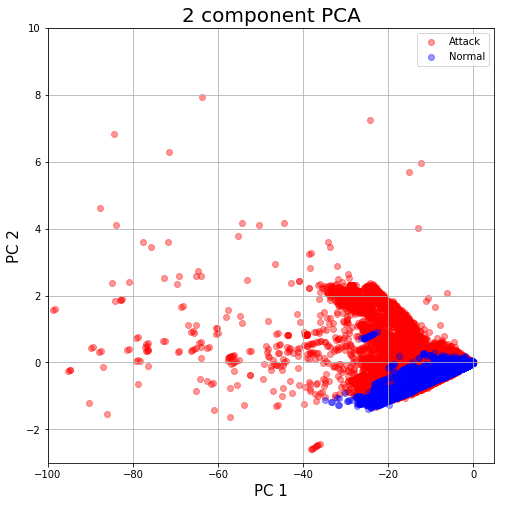

In [39]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['Attack','Normal']
ax.axis([-100, 5, -3, 10])
ax.scatter(to_plotY[0]
               , to_plotY[1]
               , c = 'r',alpha=0.4)
ax.scatter(to_plotX[0]
               , to_plotX[1]
               , c = 'b'
              ,alpha=0.4)

ax.legend(targets)
ax.grid()

From the graph above we can see that anomalous queries usually turns into an outliered points and normal queries usually stay on the same extents. Therefore we can use sparks MLlib models to help us achieve our goal.

##### To proceed from here we will need to save the points so we can restore the bag of words for future use.

In [11]:

import pickle

good_tf.union(bad_tf).saveAsTextFile("./data/htfVectors")
# sc.textFile("/data/HashedTF_Vectors").map(Vectors.parse)

with open('./data/hashedTF.pickle', 'wb') as f:
    pickle.dump(hashingTF, f)


# Train & Evaluate
### Selected models:
 1. NaiveBayes
 2. LogisticRegression
 3. SVM
 4. RandomForest

In [12]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.classification import NaiveBayes, SVMWithSGD, SVMModel
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.evaluation import MulticlassMetrics

In [15]:
# Split Data into train set and test set
[training_data, test_data] = good_tfidf.union(bad_tfidf).randomSplit([0.8, 0.2])
training_data.cache()
test_data.cache()

#helper functions:

def evaluate(name,model,test_data,params=None):
    labels = test_data.map(lambda d: d.label)
    features = test_data.map(lambda d: d.features)
    predictions = model.predict(features).map(lambda x: float(x))
    predictionsAndLabels = predictions.zip(labels)
        
    metrics = MulticlassMetrics(predictionsAndLabels)

    precision = metrics.precision()
    recall = metrics.recall()
    f1Score = metrics.fMeasure()
    accuracy = metrics.accuracy
    
    print(name) 
    if params is not None:
        print(f'parmas: [\n{params}\n]\n')      
    print('summary:')
    print(f'\nPrecision = {precision}\nRecall = {recall}\nF1 Score = {f1Score}\nAccuracy = {accuracy}\n')
    print('Confusion Matrix:\n')
    print(metrics.confusionMatrix().toArray())
    

def save_model(path, model):
    model.save(sc, path)



# Naive Bayes Classifier Model

In [16]:
name = "Naive Bayes Classifier"
params = 'lambda_=1.0'
nvc = NaiveBayes.train(training_data)
evaluate(name, nvc, test_data, params=params.replace(",","\n"))
save_model('./models/' + name.replace(" ","_"), nvc)

Naive Bayes Classifier
parmas: [
lambda_=1.0
]

summary:

Precision = 0.9873348522845434
Recall = 0.9873348522845434
F1 Score = 0.9873348522845434
Accuracy = 0.9873348522845434

Confusion Matrix:

[[251576.   1097.]
 [  2216.   6695.]]


# Logistic Regression Model

In [17]:
name = 'Logistic Regression'
params = "iterations=100, initialWeights=None, regParam=0.001, regType='l2', intercept=False, corrections=10, tolerance=1e-06, validateData=True, numClasses=2"

logreg = LogisticRegressionWithLBFGS.train(training_data,regParam=0.001)

evaluate(name, logreg, test_data, params=params.replace(",","\n"))
save_model('./models/' + name.replace(" ","_"), logreg)

Logistic Regression
parmas: [
iterations=100
 initialWeights=None
 regParam=0.001
 regType='l2'
 intercept=False
 corrections=10
 tolerance=1e-06
 validateData=True
 numClasses=2
]

summary:

Precision = 0.9896973821028809
Recall = 0.9896973821028809
F1 Score = 0.9896973821028809
Accuracy = 0.9896973821028809

Confusion Matrix:

[[251928.    745.]
 [  1950.   6961.]]


# SVM Model

In [18]:
name = 'SVM Model'
params = "iterations=100,step=1.0,regParam=0.01,miniBatchFraction=1.0,initialWeights=None,regType='l2',intercept=False,validateData=True,convergenceTol=0.001"
svm = SVMWithSGD.train(training_data, iterations=100)
evaluate(name, svm, test_data, params=params.replace(",","\n"))
save_model('./models/' + name.replace(" ","_"), svm)

SVM Model
parmas: [
iterations=100
step=1.0
regParam=0.01
miniBatchFraction=1.0
initialWeights=None
regType='l2'
intercept=False
validateData=True
convergenceTol=0.001
]

summary:

Precision = 0.9891239525353233
Recall = 0.9891239525353233
F1 Score = 0.9891239525353233
Accuracy = 0.9891239525353233

Confusion Matrix:

[[252142.    531.]
 [  2314.   6597.]]


# Random Forest Model

In [33]:
name = 'Random Forest'
params = "numClasses=2, categoricalFeaturesInfo={},numTrees=60, featureSubsetStrategy='auto',impurity='gini', maxDepth=30, maxBins=32"

rf = RandomForest.trainClassifier(
    training_data,
    numClasses=2,
    categoricalFeaturesInfo={},
    numTrees=64, 
    featureSubsetStrategy="auto",
    impurity='gini',
    maxDepth=30,
    maxBins=64,
    seed =42
)

evaluate(name, rf, test_data, params=params.replace(",","\n"))
save_model('./models/' + name.replace(" ","_"), rf)

Random Forest
parmas: [
numClasses=2
 categoricalFeaturesInfo={}
numTrees=60
 featureSubsetStrategy='auto'
impurity='gini'
 maxDepth=30
 maxBins=32
]

summary:

Precision = 0.9779611902868677
Recall = 0.9779611902868677
F1 Score = 0.9779611902868677
Accuracy = 0.9779611902868677

Confusion Matrix:

[[252673.      0.]
 [  5765.   3146.]]


# Summary
As we can see the models that performed well and have the best score were the SVM , and Logistic Regression Model